In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = 'data-science-bowl-2018/stage1_train/'
TEST_PATH = 'data-science-bowl-2018/stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

Using TensorFlow backend.


In [2]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [3]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


100%|██████████| 670/670 [01:47<00:00,  6.21it/s]


Getting and resizing test images ... 


100%|██████████| 65/65 [00:00<00:00, 67.21it/s]


Done!


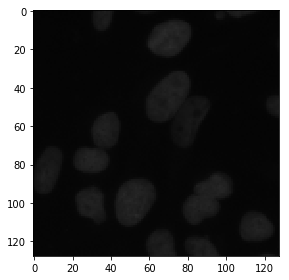

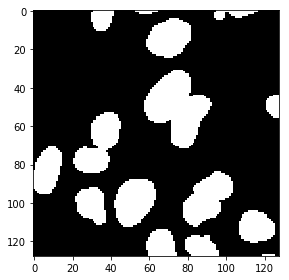

In [4]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [5]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [6]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 128, 128, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

In [7]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[earlystopper, checkpointer])

Train on 603 samples, validate on 67 samples
Epoch 1/50
603/603 [==============================] - ETA: 2:46 - loss: 0.6288 - mean_iou: 0.0000e+ - ETA: 2:12 - loss: 0.6055 - mean_iou: 0.2147   - ETA: 1:54 - loss: 0.5972 - mean_iou: 0.28 - ETA: 1:45 - loss: 0.5550 - mean_iou: 0.31 - ETA: 1:38 - loss: 0.5200 - mean_iou: 0.33 - ETA: 1:34 - loss: 0.5051 - mean_iou: 0.35 - ETA: 1:30 - loss: 0.5022 - mean_iou: 0.36 - ETA: 1:27 - loss: 0.4839 - mean_iou: 0.37 - ETA: 1:23 - loss: 0.4739 - mean_iou: 0.37 - ETA: 1:19 - loss: 0.4598 - mean_iou: 0.38 - ETA: 1:15 - loss: 0.4518 - mean_iou: 0.38 - ETA: 1:12 - loss: 0.4354 - mean_iou: 0.38 - ETA: 1:09 - loss: 0.4276 - mean_iou: 0.39 - ETA: 1:06 - loss: 0.4177 - mean_iou: 0.39 - ETA: 1:02 - loss: 0.4162 - mean_iou: 0.39 - ETA: 59s - loss: 0.4072 - mean_iou: 0.4013 - ETA: 56s - loss: 0.4056 - mean_iou: 0.404 - ETA: 53s - loss: 0.3993 - mean_iou: 0.406 - ETA: 50s - loss: 0.3922 - mean_iou: 0.409 - ETA: 48s - loss: 0.3866 - mean_iou: 0.412 - ETA: 45s - l

603/603 [==============================] - ETA: 1:31 - loss: 0.0826 - mean_iou: 0.77 - ETA: 1:28 - loss: 0.0741 - mean_iou: 0.77 - ETA: 1:25 - loss: 0.0716 - mean_iou: 0.77 - ETA: 1:23 - loss: 0.0772 - mean_iou: 0.77 - ETA: 1:21 - loss: 0.0889 - mean_iou: 0.77 - ETA: 1:18 - loss: 0.0885 - mean_iou: 0.77 - ETA: 1:16 - loss: 0.0858 - mean_iou: 0.77 - ETA: 1:13 - loss: 0.0823 - mean_iou: 0.77 - ETA: 1:11 - loss: 0.0804 - mean_iou: 0.77 - ETA: 1:08 - loss: 0.0821 - mean_iou: 0.77 - ETA: 1:06 - loss: 0.0810 - mean_iou: 0.77 - ETA: 1:03 - loss: 0.0796 - mean_iou: 0.77 - ETA: 1:01 - loss: 0.0837 - mean_iou: 0.77 - ETA: 58s - loss: 0.0836 - mean_iou: 0.7793 - ETA: 56s - loss: 0.0829 - mean_iou: 0.779 - ETA: 54s - loss: 0.0854 - mean_iou: 0.779 - ETA: 51s - loss: 0.0851 - mean_iou: 0.779 - ETA: 49s - loss: 0.0858 - mean_iou: 0.779 - ETA: 47s - loss: 0.0854 - mean_iou: 0.779 - ETA: 44s - loss: 0.0864 - mean_iou: 0.779 - ETA: 42s - loss: 0.0868 - mean_iou: 0.779 - ETA: 39s - loss: 0.0862 - mean_i

603/603 [==============================] - ETA: 1:31 - loss: 0.0841 - mean_iou: 0.81 - ETA: 1:28 - loss: 0.0726 - mean_iou: 0.81 - ETA: 1:26 - loss: 0.0779 - mean_iou: 0.81 - ETA: 1:23 - loss: 0.0769 - mean_iou: 0.81 - ETA: 1:21 - loss: 0.0814 - mean_iou: 0.81 - ETA: 1:18 - loss: 0.0793 - mean_iou: 0.81 - ETA: 1:16 - loss: 0.0769 - mean_iou: 0.81 - ETA: 1:13 - loss: 0.0765 - mean_iou: 0.81 - ETA: 1:11 - loss: 0.0743 - mean_iou: 0.81 - ETA: 1:08 - loss: 0.0739 - mean_iou: 0.81 - ETA: 1:06 - loss: 0.0731 - mean_iou: 0.81 - ETA: 1:03 - loss: 0.0736 - mean_iou: 0.81 - ETA: 1:01 - loss: 0.0720 - mean_iou: 0.81 - ETA: 58s - loss: 0.0717 - mean_iou: 0.8169 - ETA: 56s - loss: 0.0712 - mean_iou: 0.816 - ETA: 53s - loss: 0.0751 - mean_iou: 0.816 - ETA: 51s - loss: 0.0758 - mean_iou: 0.817 - ETA: 49s - loss: 0.0752 - mean_iou: 0.817 - ETA: 46s - loss: 0.0752 - mean_iou: 0.817 - ETA: 44s - loss: 0.0755 - mean_iou: 0.817 - ETA: 41s - loss: 0.0755 - mean_iou: 0.817 - ETA: 39s - loss: 0.0747 - mean_i

In [37]:
# Predict on train, val and test
model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

65/65 [==============================] - ETA:  - ETA:  - 3s 46ms/step


In [51]:
preds_train_t[1]
preds_train_t[1].shape

(128, 128, 1)

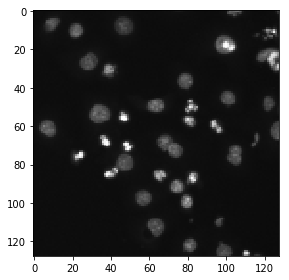

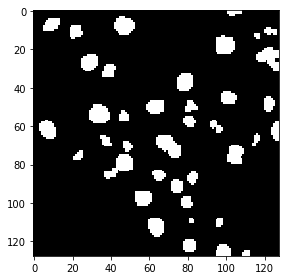

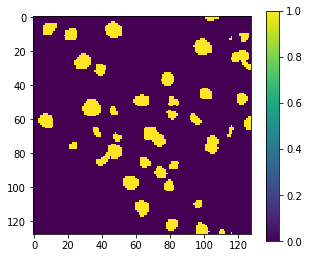

In [70]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

# Hay que hacerlo de esta manera si no no sale bien el colorbar
#imshow(np.squeeze(preds_val_t[ix]))
#plt.show()
fig = plt.figure()
ax1 = fig.add_subplot(111)
img = ax1.imshow(np.squeeze(preds_train_t[ix]))
cbaxes = fig.add_axes([0.8, 0.1, 0.03, 0.8]) 
cb = plt.colorbar(img, cax=cbaxes)


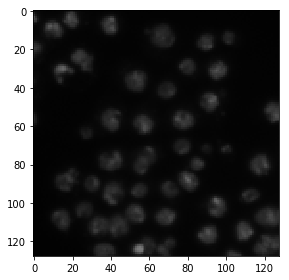

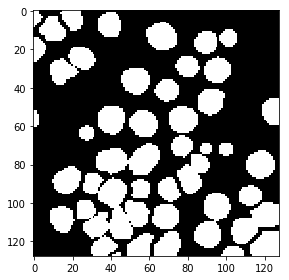

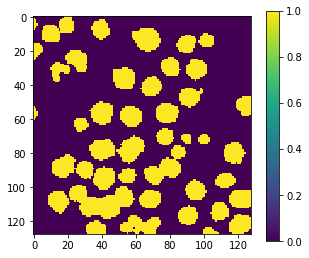

In [109]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()

# Hay que hacerlo de esta manera si no no sale bien el colorbar
#imshow(np.squeeze(preds_val_t[ix]))
#plt.show()
fig = plt.figure()
ax1 = fig.add_subplot(111)
img = ax1.imshow(np.squeeze(preds_val_t[ix]))
cbaxes = fig.add_axes([0.8, 0.1, 0.03, 0.8]) 
cb = plt.colorbar(img, cax=cbaxes)

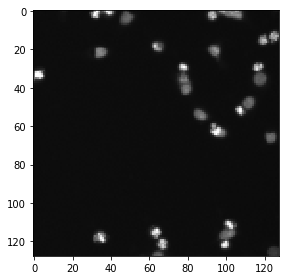

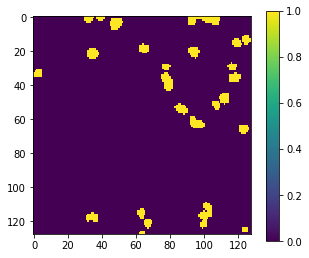

In [108]:
# Ver alguna imagen random del data test
ix = random.randint(0, len(preds_val_t))
imshow(X_test[ix])
plt.show()

# Hay que hacerlo de esta manera si no no sale bien el colorbar
fig = plt.figure()
ax1 = fig.add_subplot(111)
img = ax1.imshow(np.squeeze(preds_test_t[ix]))
cbaxes = fig.add_axes([0.8, 0.1, 0.03, 0.8]) 
cb = plt.colorbar(img, cax=cbaxes)
